In [1]:
# First let's import
# Let's do our imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pandas_profiling
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor, plot_importance
from sportsreference.nba.roster import Roster, Player
from sportsreference.nba.player import AbstractPlayer
from sportsreference.nba.teams import Teams
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
rawpast = pd.read_csv("https://raw.githubusercontent.com/Build-Week-NBA-Longevity-Predictor/Data-Science/master/1976_to_2015_Draftees_edit2.csv")

pd.set_option('display.max_columns', 90)
rawpast.head(10)


,Unnamed: 0,Player,All_NBA,All.Star,Draft_Yr,Pk,Team,College,Yrs,Games,Minutes.Played,PTS,TRB,AST,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,Win.Share,WS_per_game,BPM,VORP,Executive,Tenure,Exec_ID,Exec_draft_exp,attend_college,first_year,second_year,third_year,fourth_year,fifth_year
0,1,Robert Parish,2,9,1976,8,GSW,Centenary College of Louisiana,21,1611,45704,23334,14715,2180,0.537,0.0,0.721,28.4,14.5,9.1,1.4,147.0,0.154,1.6,41.5,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
1,2,Sonny Parker,0,0,1976,17,GSW,Texas A&M University,6,452,10916,4471,1841,954,0.501,0.0,0.755,24.2,9.9,4.1,2.1,26.9,0.118,2.2,11.5,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
2,3,Marshall Rogers,0,0,1976,34,GSW,University of Texas-Pan American,1,26,176,100,11,10,0.371,0.0,0.933,6.8,3.8,0.4,0.4,-0.2,-0.043,-9.9,-0.4,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
3,4,Jeff Fosnes,0,0,1976,68,GSW,Vanderbilt University,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
4,5,Carl Bird,0,0,1976,86,GSW,University of California,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
5,6,Duane Barnett,0,0,1976,91,GSW,Stanford University,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
6,7,Gene Cunningham,0,0,1976,104,GSW,Norfolk State University,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
7,8,Jesse Campbell,0,0,1976,122,GSW,Mercyhurst College,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
8,9,Stan Boskovich,0,0,1976,140,GSW,West Virginia University,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
9,10,Howard Smith,0,0,1976,157,GSW,University of San Francisco,0,0,0,0,0,0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0


In [ ]:
# profile = rawpast.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file="rawpastprofile.html")

In [3]:
import itertools

teams = Teams()
teamabbs = []
squadnames=[]

for team in teams:
    teamabbs.append(team.abbreviation)

for abb in teamabbs:
    squad = Roster(abb, slim=True)
    squaddict = squad.players
    squadnames.append(list(squaddict.values()))

mergednames = list(itertools.chain.from_iterable(squadnames))

In [4]:
list(squaddict.keys())[:5]

['hensojo01', 'knighbr03', 'thomptr01', 'clarkjo01', 'dellama01']

In [5]:
list(squaddict.values())[:5]

['John Henson',
 'Brandon Knight',
 'Tristan Thompson',
 'Jordan Clarkson',
 'Matthew Dellavedova']

In [6]:
len(mergednames), mergednames[:5], rawpast.shape

(501,
 ['Maurice Harkless',
  'Lou Williams',
  'Landry Shamet',
  'Jerome Robinson',
  'Paul George'],
 (3961, 35))

In [7]:
# Now we're going to get rid of the observations with 0 years, as those rows are inherently useless to us
# We're also going to drop current NBA players (mergednames)
rawpast = rawpast[rawpast['Yrs'] != 0]
past = rawpast[~rawpast['Player'].isin(mergednames)]
past.head(10)

,Unnamed: 0,Player,All_NBA,All.Star,Draft_Yr,Pk,Team,College,Yrs,Games,Minutes.Played,PTS,TRB,AST,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,Win.Share,WS_per_game,BPM,VORP,Executive,Tenure,Exec_ID,Exec_draft_exp,attend_college,first_year,second_year,third_year,fourth_year,fifth_year
0,1,Robert Parish,2,9,1976,8,GSW,Centenary College of Louisiana,21,1611,45704,23334,14715,2180,0.537,0.000,0.721,28.4,14.5,9.1,1.4,147.0,0.154,1.6,41.5,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
1,2,Sonny Parker,0,0,1976,17,GSW,Texas A&M University,6,452,10916,4471,1841,954,0.501,0.000,0.755,24.2,9.9,4.1,2.1,26.9,0.118,2.2,11.5,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
2,3,Marshall Rogers,0,0,1976,34,GSW,University of Texas-Pan American,1,26,176,100,11,10,0.371,0.000,0.933,6.8,3.8,0.4,0.4,-0.2,-0.043,-9.9,-0.4,Al Attles,3641 days 00:00:00.000000000,1,1,1,0,0,0,0,0
11,12,Rickey Green,0,0,1977,16,GSW,University of Michigan,14,946,23271,8870,1819,5221,0.469,0.207,0.807,24.6,9.4,1.9,5.5,47.2,0.097,-1.0,5.8,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
12,13,Wesley Cox,0,0,1977,18,GSW,University of Louisville,2,74,813,342,206,23,0.412,0.000,0.510,11.0,4.6,2.8,0.3,0.1,0.007,-6.9,-1.0,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
14,15,Marlon Redmond,0,0,1977,60,GSW,University of San Francisco,2,77,1057,499,161,77,0.423,0.000,0.655,13.7,6.5,2.1,1.0,0.6,0.026,-3.8,-0.5,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
17,18,Ray Epps,0,0,1977,104,GSW,Norfolk State University,1,13,72,26,5,2,0.435,0.000,0.750,5.5,2.0,0.4,0.2,0.1,0.057,-6.9,-0.1,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
20,21,Ricky Marsh,0,0,1977,165,GSW,Manhattan College,1,60,851,269,75,90,0.426,0.000,0.697,14.2,4.5,1.3,1.5,0.5,0.028,-4.3,-0.5,Al Attles,3641 days 00:00:00.000000000,1,2,1,0,0,0,0,0
21,22,Purvis Short,0,0,1978,5,GSW,Jackson State University,12,842,24549,14607,3625,2123,0.474,0.282,0.824,29.2,17.3,4.3,2.5,51.1,0.100,-0.1,11.6,Al Attles,3641 days 00:00:00.000000000,1,3,1,0,0,0,0,0
22,23,Raymond Townsend,0,0,1978,22,GSW,"University of California, Los Angeles",3,154,2025,745,157,217,0.411,0.171,0.703,13.1,4.8,1.0,1.4,1.0,0.023,-4.6,-1.3,Al Attles,3641 days 00:00:00.000000000,1,3,1,0,0,0,0,0


In [8]:
train, val = train_test_split(past, train_size=0.80, test_size=0.20, random_state=42)

# With the information we get from the pandas profiler we can now organize our data
def organize(X):
    X = X.copy()
    # Let's name some features that we don't need, Duplicates and Meaningless
    # and a few that would bleed into our model , Obvious
    duplicates = ['Win.Share', 'Unnamed: 0', 'Executive']
    meaningless = ['Draft_Yr', 'first_year', 'second_year', 'third_year', 'fourth_year', 'fifth_year']
    obvious = ['PTS', 'TRB', 'AST', 'Minutes.Played', 'Games', 'VORP']
    
    # Now let's do a cosmetic change to College
    X['College'] = X['College'].replace('0', 'None')
    
    # And we'll make Tenure(days) from the Tenure feature
    X['Tenure(days)'] = X['Tenure'].map(lambda x: str(x)[:-24]).astype('int64')
    
    # We'll add Tenure to duplicates
    duplicates = duplicates + ['Tenure']
    
    # Now let's drop the features we don't need
    todrop = duplicates + meaningless + obvious
    X = X.drop(columns=todrop)
    
    return X

train = organize(train)
val = organize(val)
    

In [9]:
train.sample(8)

,Player,All_NBA,All.Star,Pk,Team,College,Yrs,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,WS_per_game,BPM,Exec_ID,Exec_draft_exp,attend_college,Tenure(days)
1175,Clifford Rozier,0,0,16,GSW,University of Louisville,4,0.496,0.182,0.465,17.2,4.8,5.2,0.6,0.063,-2.1,49,17,1,2601
3951,Mark Radford,0,0,53,OKC,Oregon State University,2,0.507,0.286,0.458,8.3,3.6,0.8,1.7,0.023,-3.4,162,5,1,2189
3891,Chucky Brown,0,0,43,CLE,North Carolina State University,13,0.491,0.227,0.699,17.2,5.9,3.1,0.8,0.076,-3.0,159,4,1,4730
2732,Cheikh Samb,0,0,51,LAL,None,2,0.250,0.000,0.444,5.2,1.0,1.4,0.0,-0.056,-9.2,117,5,0,5898
2779,Stan Pietkiewicz,0,0,133,LAC,Auburn University,3,0.458,0.333,0.806,11.1,3.9,1.0,1.8,0.066,-2.8,119,2,1,481
33,Cheese Johnson,0,0,54,GSW,Wichita State University,1,0.400,0.000,0.600,5.9,3.0,1.6,0.2,-0.033,-9.7,1,4,1,3641
3903,Derek Anderson,0,0,13,CLE,University of Kentucky,11,0.408,0.341,0.853,29.2,12.0,3.2,3.4,0.117,0.9,159,11,1,4730
830,Carrick Felix,0,0,33,CLE,Arizona State University,1,0.500,0.400,0.750,5.4,2.7,0.9,0.6,0.057,-4.7,28,3,1,1343


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1528 entries, 296 to 2294
Data columns (total 20 columns):
Player              1528 non-null object
All_NBA             1528 non-null int64
All.Star            1528 non-null int64
Pk                  1528 non-null int64
Team                1528 non-null object
College             1528 non-null object
Yrs                 1528 non-null int64
FG_Percentage       1528 non-null float64
TP_Percentage       1528 non-null float64
FT_Percentage       1528 non-null float64
Minutes.per.Game    1528 non-null float64
Points.per.Game     1528 non-null float64
TRB.per.game        1528 non-null float64
Assits.per.Game     1528 non-null float64
WS_per_game         1528 non-null float64
BPM                 1528 non-null float64
Exec_ID             1528 non-null int64
Exec_draft_exp      1528 non-null int64
attend_college      1528 non-null int64
Tenure(days)        1528 non-null int64
dtypes: float64(9), int64(8), object(3)
memory usage: 250.7+ KB


In [11]:
# Now let's arrange x matrix and y vector
target = 'Yrs'
xtrain = train.drop(columns=target)
xval = val.drop(columns=target)

ytrain = train[target]
yval = val[target]

feats = train.drop(columns=[target]).columns.tolist()

In [12]:
feats

['Player',
 'All_NBA',
 'All.Star',
 'Pk',
 'Team',
 'College',
 'FG_Percentage',
 'TP_Percentage',
 'FT_Percentage',
 'Minutes.per.Game',
 'Points.per.Game',
 'TRB.per.game',
 'Assits.per.Game',
 'WS_per_game',
 'BPM',
 'Exec_ID',
 'Exec_draft_exp',
 'attend_college',
 'Tenure(days)']

In [13]:
len(feats)

19

In [14]:
# We'll drop some more features that won't match up with the API we useor it adds noise to the model
todrop = {'Player', 'All_NBA', 'All.Star', 'College', 'Pk', 'Exec_ID', 'Exec_draft_exp', 'attend_college', 'Tenure(days)'}
feats = [e for e in feats if e not in todrop]
feats, len(feats)

(['Team',
  'FG_Percentage',
  'TP_Percentage',
  'FT_Percentage',
  'Minutes.per.Game',
  'Points.per.Game',
  'TRB.per.game',
  'Assits.per.Game',
  'WS_per_game',
  'BPM'],
 10)

In [15]:
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [16]:
# First we'll use the average NBA career length of 5 yrs
avgyrs = 5
ypred = np.full_like(yval, avgyrs)

print(f"RMSE: {rmse(yval, ypred)}")

RMSE: 5.202697649030273


In [21]:
# Now let's use XGBoost
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
xtrainencoded = encoder.fit_transform(xtrain[feats])
xvalencoded = encoder.transform(xval[feats])
eval_set = [(xtrainencoded, ytrain),
            (xvalencoded, yval)]

model = XGBRegressor(n_estimators=586, max_depth=7, n_jobs=-1)
model.fit(xtrainencoded, ytrain, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)


[03:21:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.8483	validation_1-rmse:7.031
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:6.25628	validation_1-rmse:6.4674
[2]	validation_0-rmse:5.72788	validation_1-rmse:5.97222
[3]	validation_0-rmse:5.2553	validation_1-rmse:5.53108
[4]	validation_0-rmse:4.83168	validation_1-rmse:5.14753
[5]	validation_0-rmse:4.45222	validation_1-rmse:4.80598
[6]	validation_0-rmse:4.11708	validation_1-rmse:4.51883
[7]	validation_0-rmse:3.81629	validation_1-rmse:4.2502
[8]	validation_0-rmse:3.54538	validation_1-rmse:4.02304
[9]	validation_0-rmse:3.30572	validation_1-rmse:3.82815
[10]	validation_0-rmse:3.08621	validation_1-rmse:3.66182
[11]	validation_0-rmse:2.88833	validation_1-rmse:3.51351
[12]	validation_0-rmse:2.72161	validation_1-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=586,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

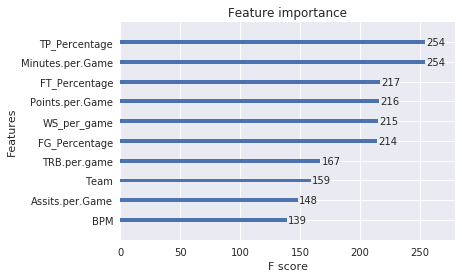

In [18]:
# Let's take a look at the feature importances
from xgboost import plot_importance

plot_importance(model)

In [19]:
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(random_state=42)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(500, 1000), 
    'xgbregressor__max_depth': randint(3, 9)
}    

# groups = train['tube_assembly_id']
    
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(xtrain, ytrain);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.6s finished


[03:20:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [20]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

# Then gonna go back up and rerun model

Best hyperparameters {'xgbregressor__max_depth': 7, 'xgbregressor__n_estimators': 586}
Cross-validation RMSLE 2.841978448003552


In [22]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

In [23]:
crossfeats = feats + ['Player']
crosspast = past[crossfeats]
crosspast.sample(5)

,Team,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,WS_per_game,BPM,Player
3540,PHO,0.205,0.167,0.875,5.9,1.1,0.6,0.5,-0.132,-10.6,Nemanja Nedovic
3787,MEM,0.483,0.500,0.532,16.9,4.8,3.5,0.4,0.035,-3.3,Roy Rogers
460,WAS,0.443,0.208,0.747,14.1,4.0,1.3,2.6,0.033,-4.5,Bryan Warrick
3796,LAC,0.468,0.307,0.807,30.6,18.1,6.1,2.1,0.112,-0.5,Tom Chambers
355,SAS,0.456,0.299,0.791,26.0,9.2,4.7,1.8,0.098,0.8,Tyrone Corbin


In [24]:
import sqlite3

conn = sqlite3.connect('nbadb.sqlite3')
cursor = conn.cursor()

nbads = pd.read_sql("select * from nba_players;", conn)

nbads.head()


,ref_id,name,Team,FG_Pct,TP_Pct,FT_Pct,Min_per_game,Pts_per_game,TRB_per_game,Asts_per_game,WS_per_game,BPM,VORP
0,gasolma01,Marc Gasol,TOR,0.483,0.349,0.777,33.413317,14.983668,7.685930,3.443467,79.5,3.4,36.3
1,powelno01,Norman Powell,TOR,0.441,0.343,0.807,16.835938,7.089844,2.132812,1.214844,7.3,-1.4,0.6
2,siakapa01,Pascal Siakam,TOR,0.529,0.310,0.748,23.612903,10.165899,5.142857,1.976959,15.7,2.3,5.5
3,anunoog01,OG Anunoby,TOR,0.461,0.350,0.600,20.204225,6.464789,2.732394,0.718310,5.0,-0.4,1.2
4,lowryky01,Kyle Lowry,TOR,0.423,0.367,0.805,31.302217,14.442240,4.269545,6.102684,86.8,3.8,39.3


In [25]:
renamedict = {'name': 'Player', 'FG_Pct': 'FG_Percentage', 'TP_Pct': 'TP_Percentage', 'FT_Pct': 'FT_Percentage', 
              'Min_per_game': 'Minutes.per.Game', 'Pts_per_game': 'Points.per.Game', 'TRB_per_game': 'TRB.per.game',
              'Asts_per_game': 'Assits.per.Game'}

nbads = nbads.rename(columns=renamedict)
nbads.head()

,ref_id,Player,Team,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,WS_per_game,BPM,VORP
0,gasolma01,Marc Gasol,TOR,0.483,0.349,0.777,33.413317,14.983668,7.685930,3.443467,79.5,3.4,36.3
1,powelno01,Norman Powell,TOR,0.441,0.343,0.807,16.835938,7.089844,2.132812,1.214844,7.3,-1.4,0.6
2,siakapa01,Pascal Siakam,TOR,0.529,0.310,0.748,23.612903,10.165899,5.142857,1.976959,15.7,2.3,5.5
3,anunoog01,OG Anunoby,TOR,0.461,0.350,0.600,20.204225,6.464789,2.732394,0.718310,5.0,-0.4,1.2
4,lowryky01,Kyle Lowry,TOR,0.423,0.367,0.805,31.302217,14.442240,4.269545,6.102684,86.8,3.8,39.3


In [26]:
reorderlist = ['Team', 'FG_Percentage', 'TP_Percentage', 'FT_Percentage', 'Minutes.per.Game', 'Points.per.Game' ,'TRB.per.game',
               'Assits.per.Game', 'WS_per_game', 'BPM', 'VORP', 'Player']

nbads = nbads[reorderlist]
nbads.head()

,Team,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,WS_per_game,BPM,VORP,Player
0,TOR,0.483,0.349,0.777,33.413317,14.983668,7.685930,3.443467,79.5,3.4,36.3,Marc Gasol
1,TOR,0.441,0.343,0.807,16.835938,7.089844,2.132812,1.214844,7.3,-1.4,0.6,Norman Powell
2,TOR,0.529,0.310,0.748,23.612903,10.165899,5.142857,1.976959,15.7,2.3,5.5,Pascal Siakam
3,TOR,0.461,0.350,0.600,20.204225,6.464789,2.732394,0.718310,5.0,-0.4,1.2,OG Anunoby
4,TOR,0.423,0.367,0.805,31.302217,14.442240,4.269545,6.102684,86.8,3.8,39.3,Kyle Lowry


In [27]:
nbads.shape

(426, 12)

In [28]:
# nbads.to_csv('nbads.csv')
chkdata = nbads[nbads['Player'] == 'Ben Simmons']
chkdata

,Team,FG_Percentage,TP_Percentage,FT_Percentage,Minutes.per.Game,Points.per.Game,TRB.per.game,Assits.per.Game,WS_per_game,BPM,VORP,Player
213,PHI,0.555,0.0,0.581,33.956522,16.397516,8.47205,7.950311,17.7,4.3,8.8,Ben Simmons


In [29]:
xtestencoded = encoder.transform(chkdata.drop(columns=['Player', 'VORP']))

model.predict(xtestencoded)


array([11.047226], dtype=float32)

In [30]:
from sklearn.neighbors import NearestNeighbors

X =crosspast.drop(columns=['Player'])
coder = ce.OrdinalEncoder()
Xencoded = coder.fit_transform(X)
# nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(Xencoded)
Xencoded.isna().sum()

Team                0
FG_Percentage       0
TP_Percentage       0
FT_Percentage       0
Minutes.per.Game    0
Points.per.Game     0
TRB.per.game        0
Assits.per.Game     0
WS_per_game         0
BPM                 0
dtype: int64

In [31]:
scaler = RobustScaler()
scaler.fit(Xencoded)
Xscaled = scaler.transform(Xencoded)

reg = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(Xencoded)

In [32]:
xtestscaled = scaler.transform(xtestencoded)

distances, indices = reg.kneighbors(xtestencoded)
indices

array([[1807]])

In [38]:
finfeats = crossfeats + ['Yrs']
comppast = past[finfeats]

compplayers = comppast.iloc[indices[0]]

In [39]:
compresult = compplayers[['Player', 'Yrs']]
compresult

,Player,Yrs
3742,Fat Lever,11


In [35]:
pickle.dump(reg, open('compare.pkl', 'wb'))

In [36]:
###############
# Test Code
nbads.index[nbads['Player'] == 'Ben Simmons']

Int64Index([213], dtype='int64')